## Gaussian Mixture Models clustering

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.cluster import AgglomerativeClustering


from sklearn import datasets, metrics

In [2]:
# Load the dataset from the Thinkful's database. Here's the credentials you can use to connect to the database:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

engine.dispose()

In [3]:
heartdisease_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [5]:
heartdisease_df.shape

(303, 14)

### Prep Data

In [4]:
# The dataset needs some preprocessing. So, apply the following code before working with the dataset:

# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

In [5]:
# Standarizing the features since
# Clustering algorithms are sensitive
# the the variable scale of the metrics 
# that are used to analyze similarity

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Apply GMM to the heart disease data by setting n_components=2. 

Get ARI and silhoutte scores for your solution and compare it with those of the k-means and hierarchical clustering solutions that you implemented in the assignments of the previous checkpoints. Which algorithm does perform better?

In [83]:
# create df to hold results of each iteration

rows = ['hierarchical - ward',
       'hierarchical - complete',
       'hierarchical - average',
       'k-means',
       'gaussian - full',
       'gaussian - tied',
       'gaussian - diag',
       'gaussian - spherical']

columns = ['ARI',
          'silhouette']

results_df = pd.DataFrame(index=rows,
                         columns=columns)

In [84]:
results_df

,ARI,silhouette
hierarchical - ward,NaN,NaN
hierarchical - complete,NaN,NaN
hierarchical - average,NaN,NaN
k-means,NaN,NaN
gaussian - full,NaN,NaN
gaussian - tied,NaN,NaN
gaussian - diag,NaN,NaN
gaussian - spherical,NaN,NaN


In [10]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

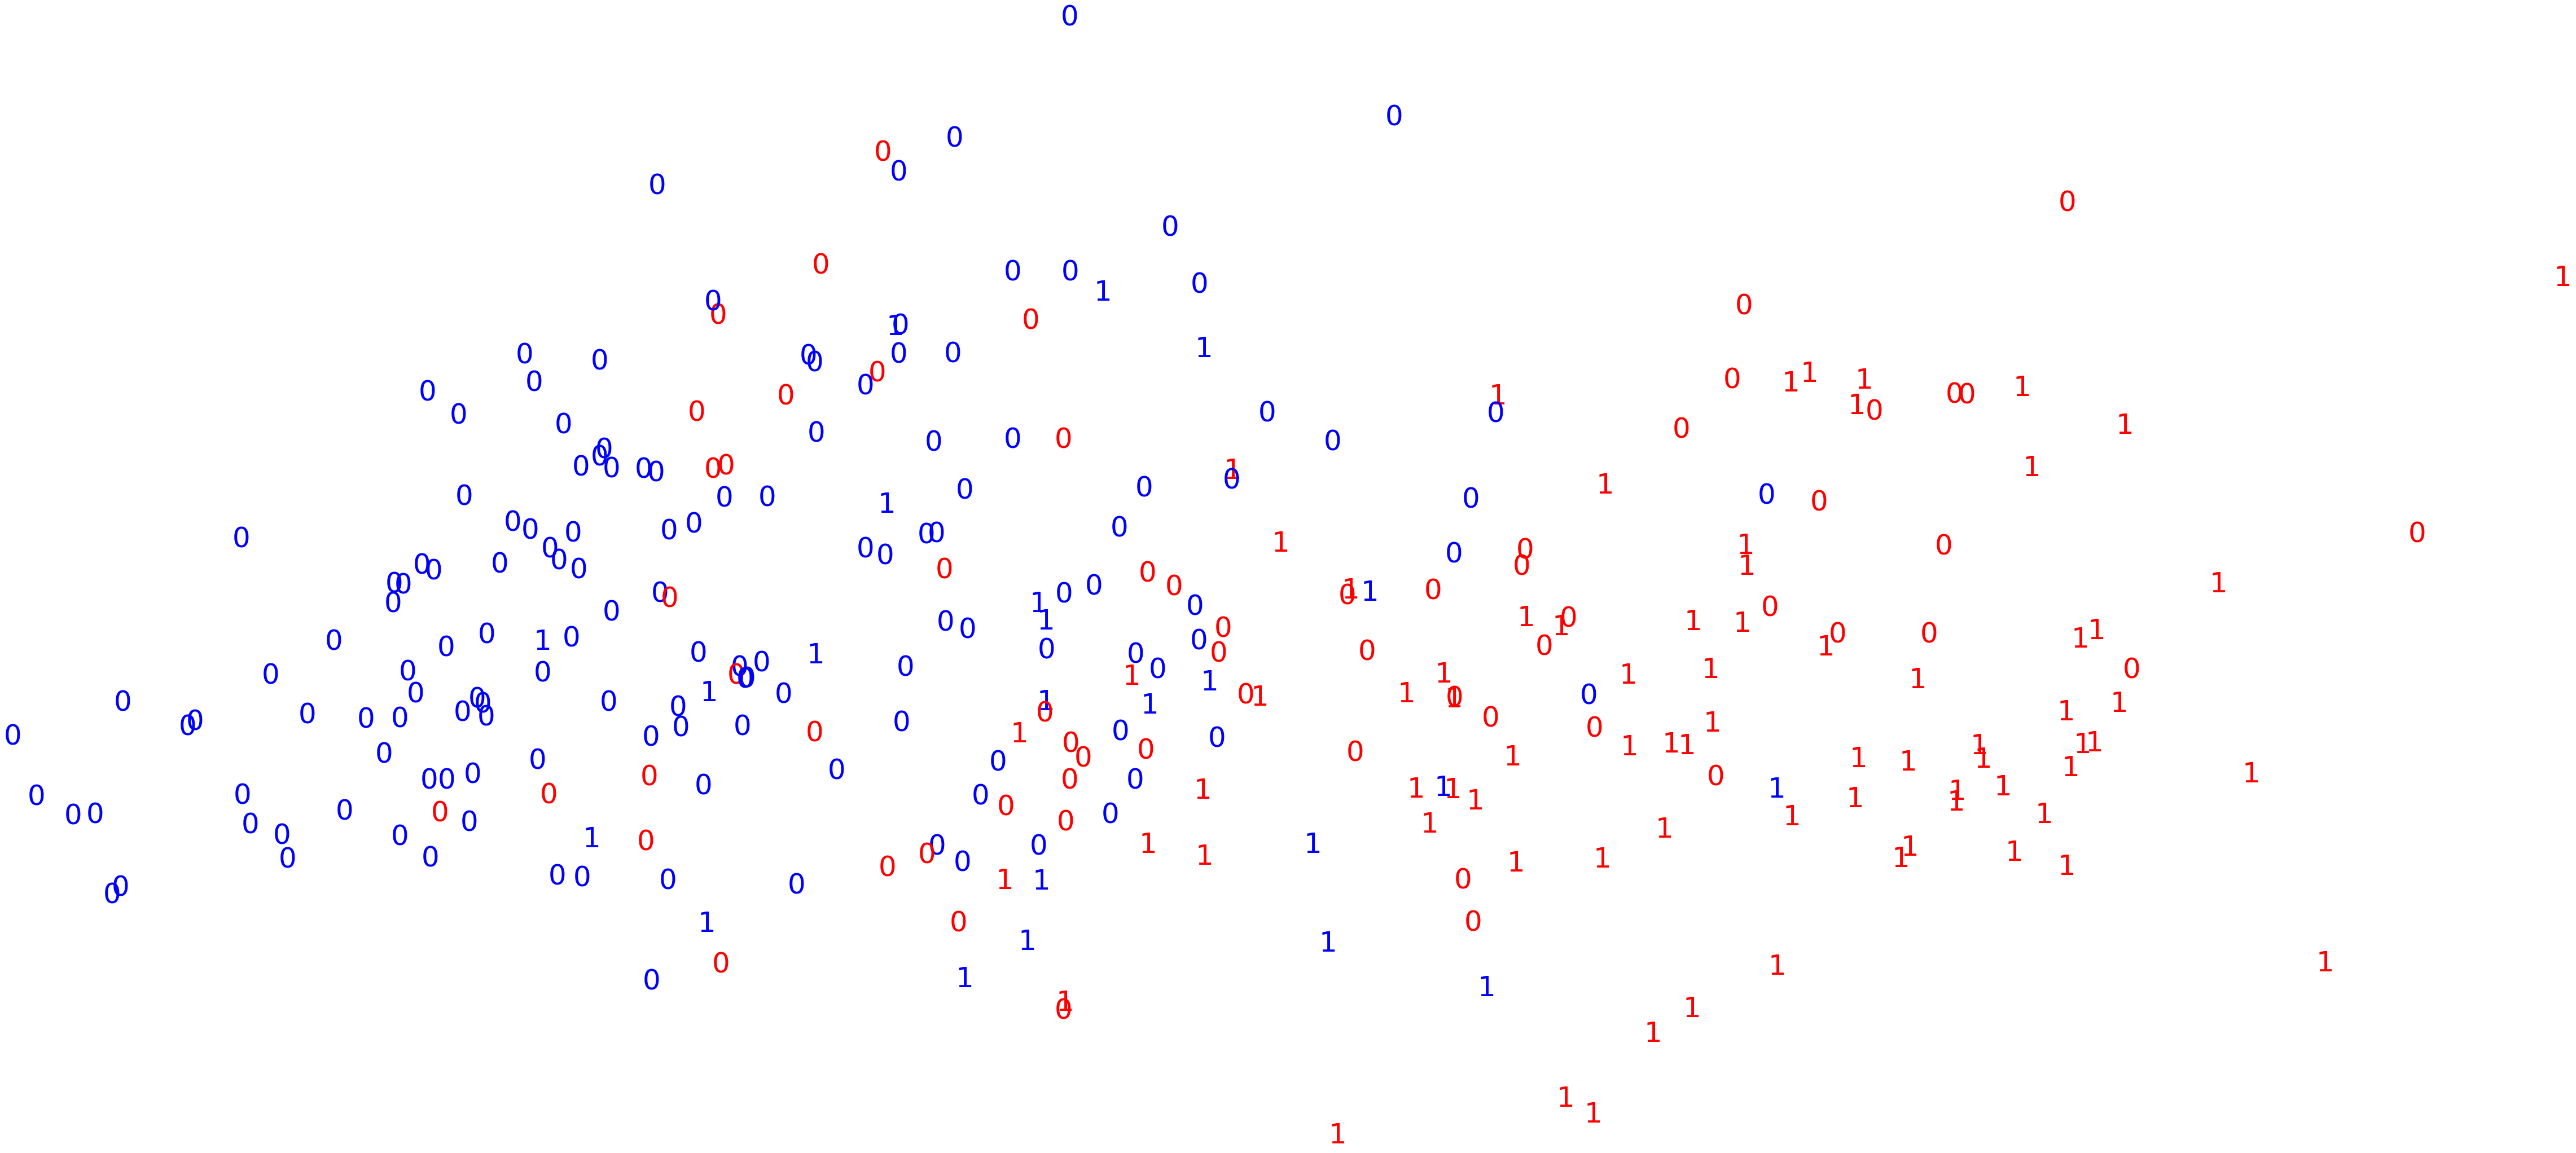

In [86]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [11]:
pd.Series(clusters).value_counts()

0    138
2     73
4     68
3     13
1     11
dtype: int64

In [87]:
# re-labeling clusters
clusters = np.array([2 if x == 1 else 1 if x==0 else 0 for x in clusters])

pd.crosstab(y,clusters)

col_0,1,2
row_0,,
0,63,76
1,141,23


In [88]:
# Examine ARI and silhouette score
results_df.loc['gaussian - full', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.136

In [89]:
results_df.loc['gaussian - full', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.184

### Compare to K-means and Hierarchical clustering from previous assignments

### K-means with 2 clusters (from prior assignment)

In [90]:
# ARI
full_pred = KMeans(n_clusters=2).fit_predict(X_std)

full_pred = np.array([0 if x == 1 else 1 if x==0 else 2 for x in full_pred])

pd.crosstab(y, full_pred)
results_df.loc['k-means', 'ARI'] = round(metrics.adjusted_rand_score(y, full_pred), 3)

In [91]:
# silhouette
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)

results_df.loc['k-means', 'silhouette'] = round(metrics.silhouette_score(X_std, labels, metric='euclidean'), 3)

### Hierarchical Clustering (from prior assignment)

### 1. Ward - In general, this method tends to find clusters of similar size

In [92]:
# Defining the agglomerative clustering
# remember, ward only works with Euclidian
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [93]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - ward', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.146

In [94]:
# examine silhouette score
results_df.loc['hierarchical - ward', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.139

### 2. Complete - Clusters tend to be comprised of highly similar observations, making the resulting groups quite compact.

In [95]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [96]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - complete', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.214

In [97]:
# examine silhouette score
results_df.loc['hierarchical - complete', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.117

### 3. Average - it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

In [98]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

In [99]:
# examine Adjusted Rand Index (ARI) and the silhouette scores
results_df.loc['hierarchical - average', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.294

In [100]:
# examine silhouette score
results_df.loc['hierarchical - average', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.148

In [101]:
results_df

,ARI,silhouette
hierarchical - ward,0.146,0.139
hierarchical - complete,0.214,0.117
hierarchical - average,0.294,0.148
k-means,0.438,0.175
gaussian - full,0.184,0.136
gaussian - tied,NaN,NaN
gaussian - diag,NaN,NaN
gaussian - spherical,NaN,NaN


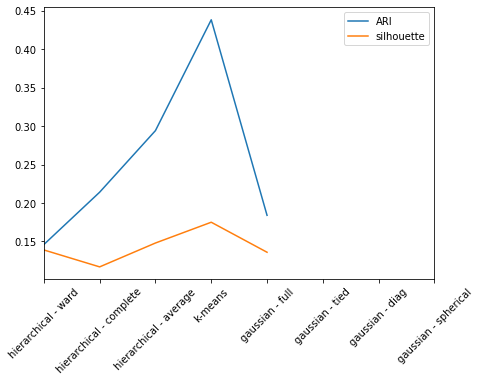

In [102]:
results_df.plot(figsize=(7,5))
plt.xticks(rotation=45);

# GMM implementation of scikit-learn has a parameter called covariance_type. This parameter determines the type of covariance parameters to use. Specifically, there are four types you can specify:

 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

Try all of these. Which one does perform better in terms of ARI and silhouette scores?

## tied

In [103]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

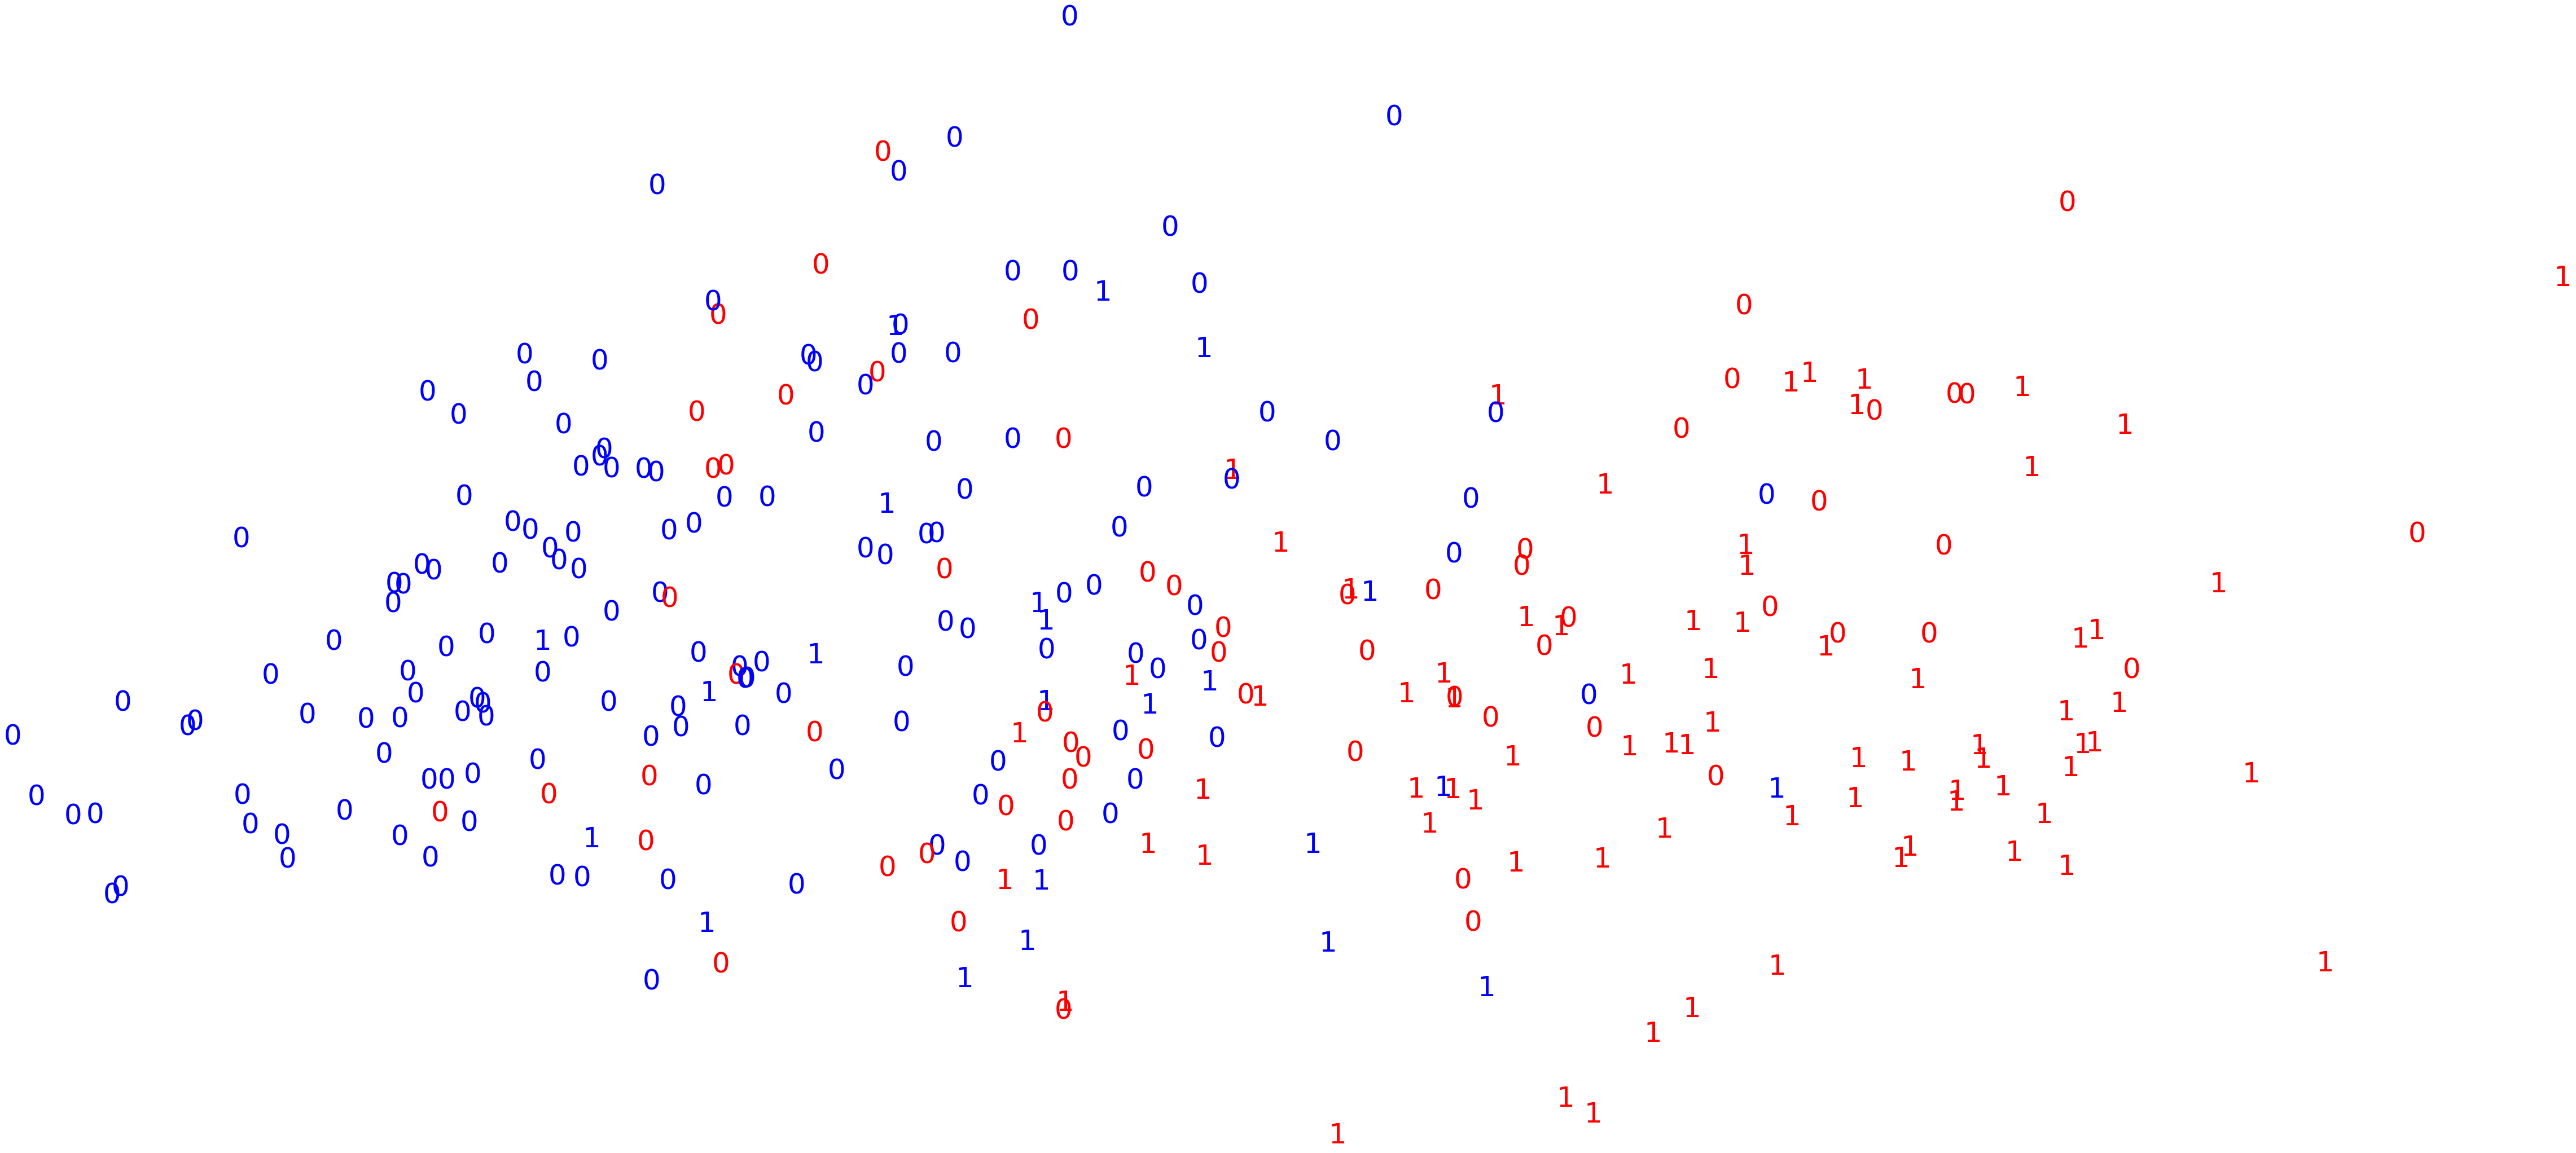

In [104]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [105]:
# re-labeling clusters
clusters = np.array([2 if x == 1 else 1 if x==0 else 0 for x in clusters])

pd.crosstab(y,clusters)

col_0,1,2
row_0,,
0,63,76
1,141,23


In [106]:
# Examine ARI and silhouette score
results_df.loc['gaussian - tied', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.136

In [107]:
results_df.loc['gaussian - tied', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.184

## diag

In [108]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

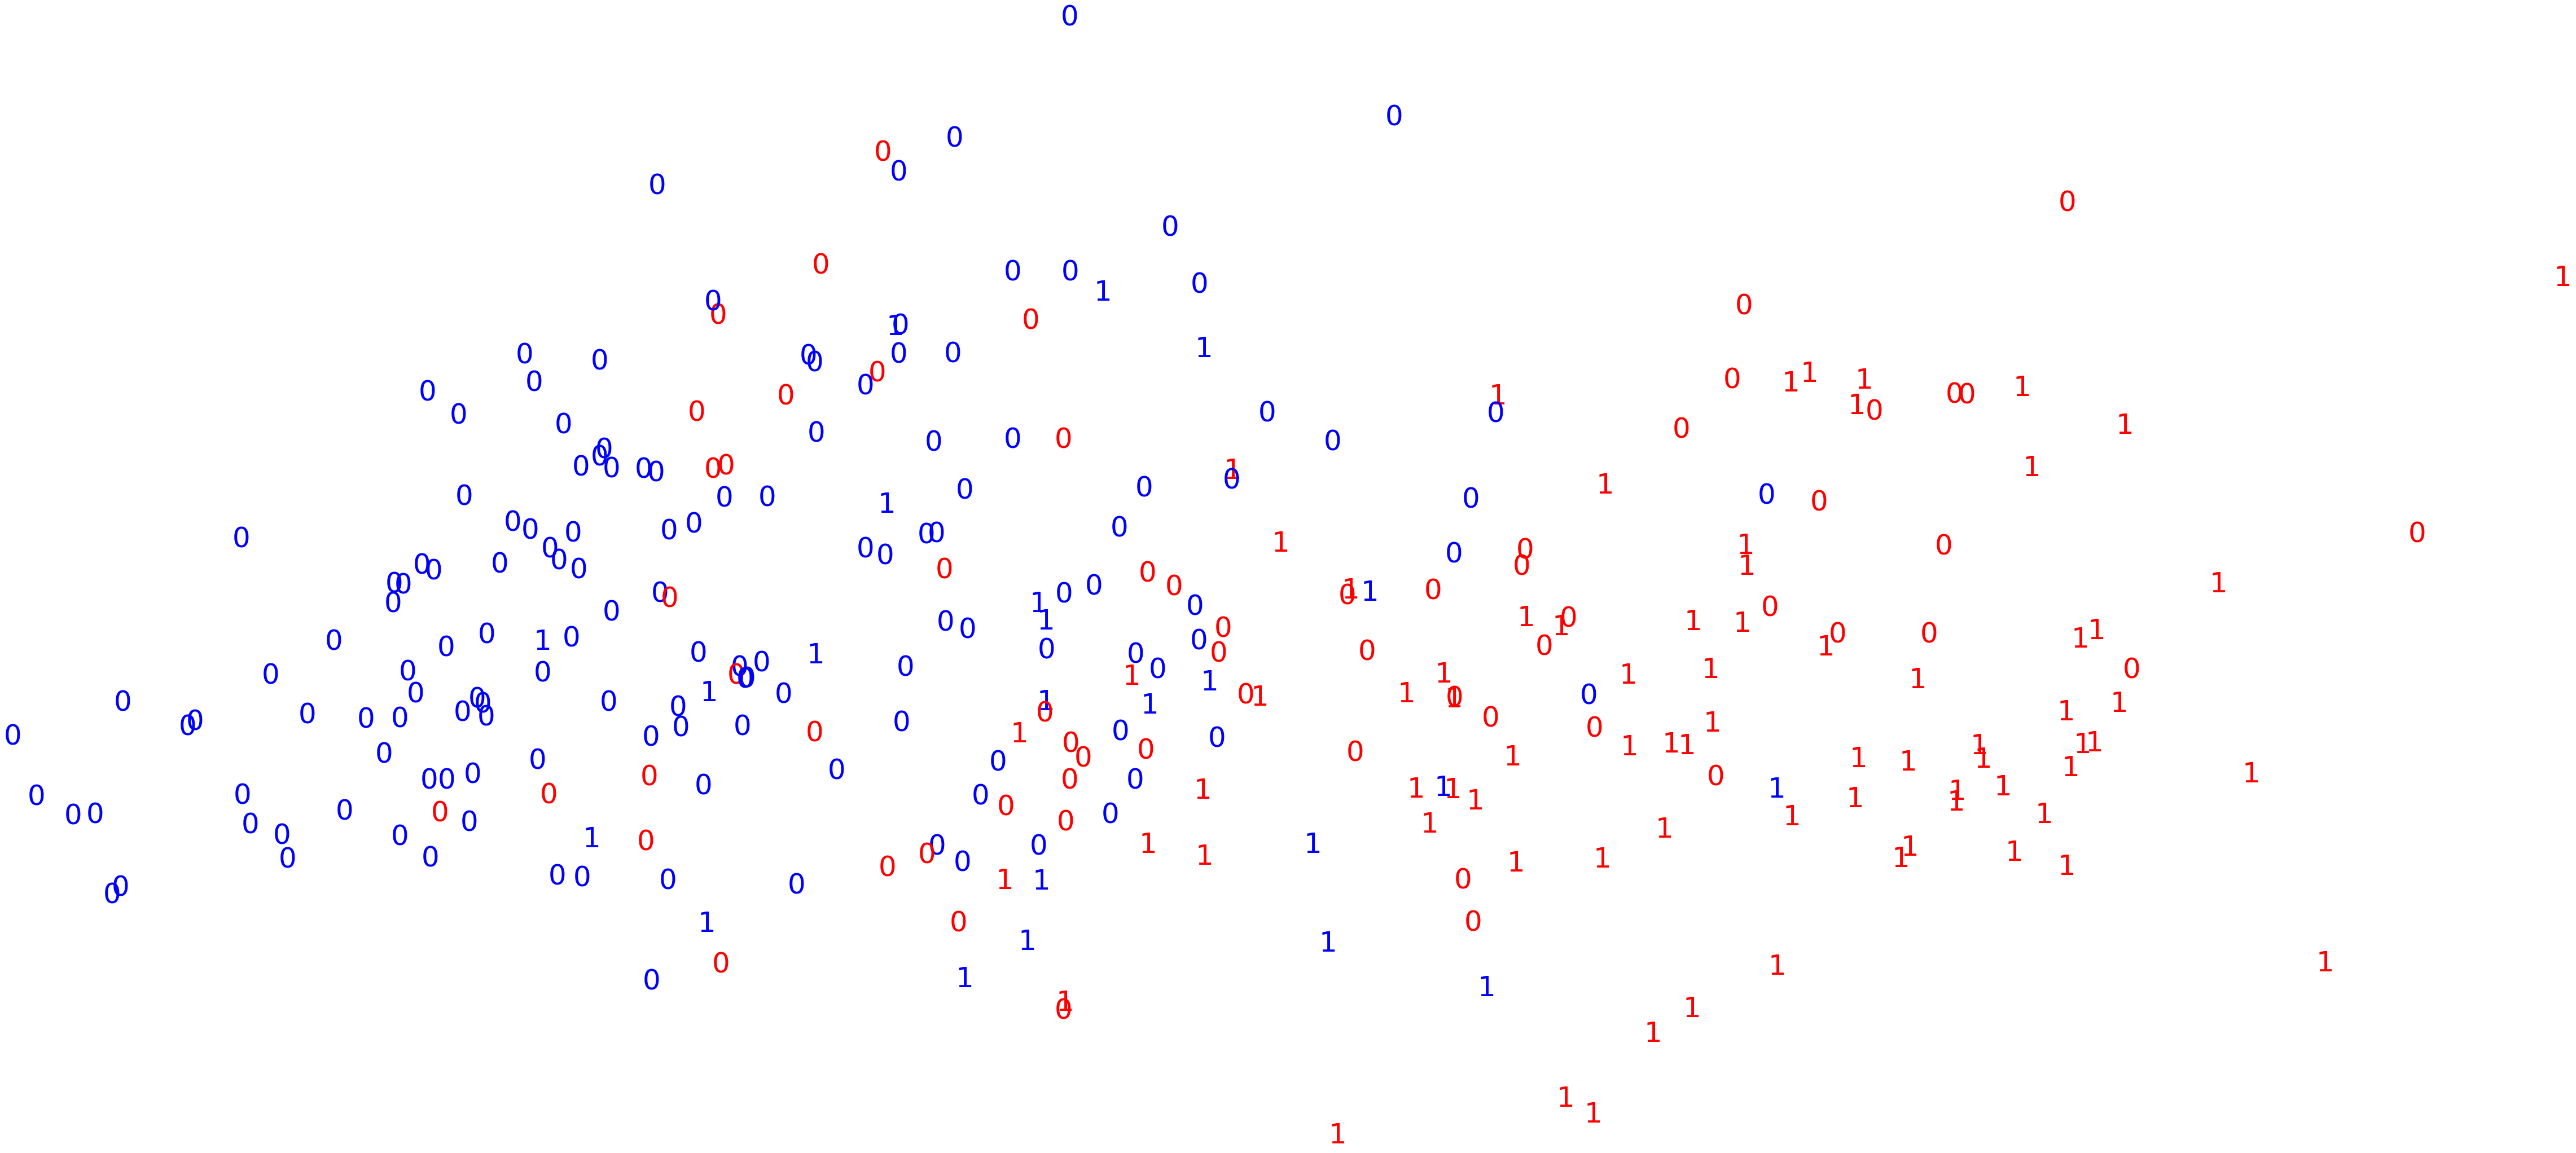

In [109]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [110]:
# re-labeling clusters
clusters = np.array([2 if x == 1 else 1 if x==0 else 0 for x in clusters])

pd.crosstab(y,clusters)

col_0,1,2
row_0,,
0,63,76
1,141,23


In [111]:
# Examine ARI and silhouette score
results_df.loc['gaussian - diag', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.136

In [112]:
results_df.loc['gaussian - diag', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.184

## spherical

In [113]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

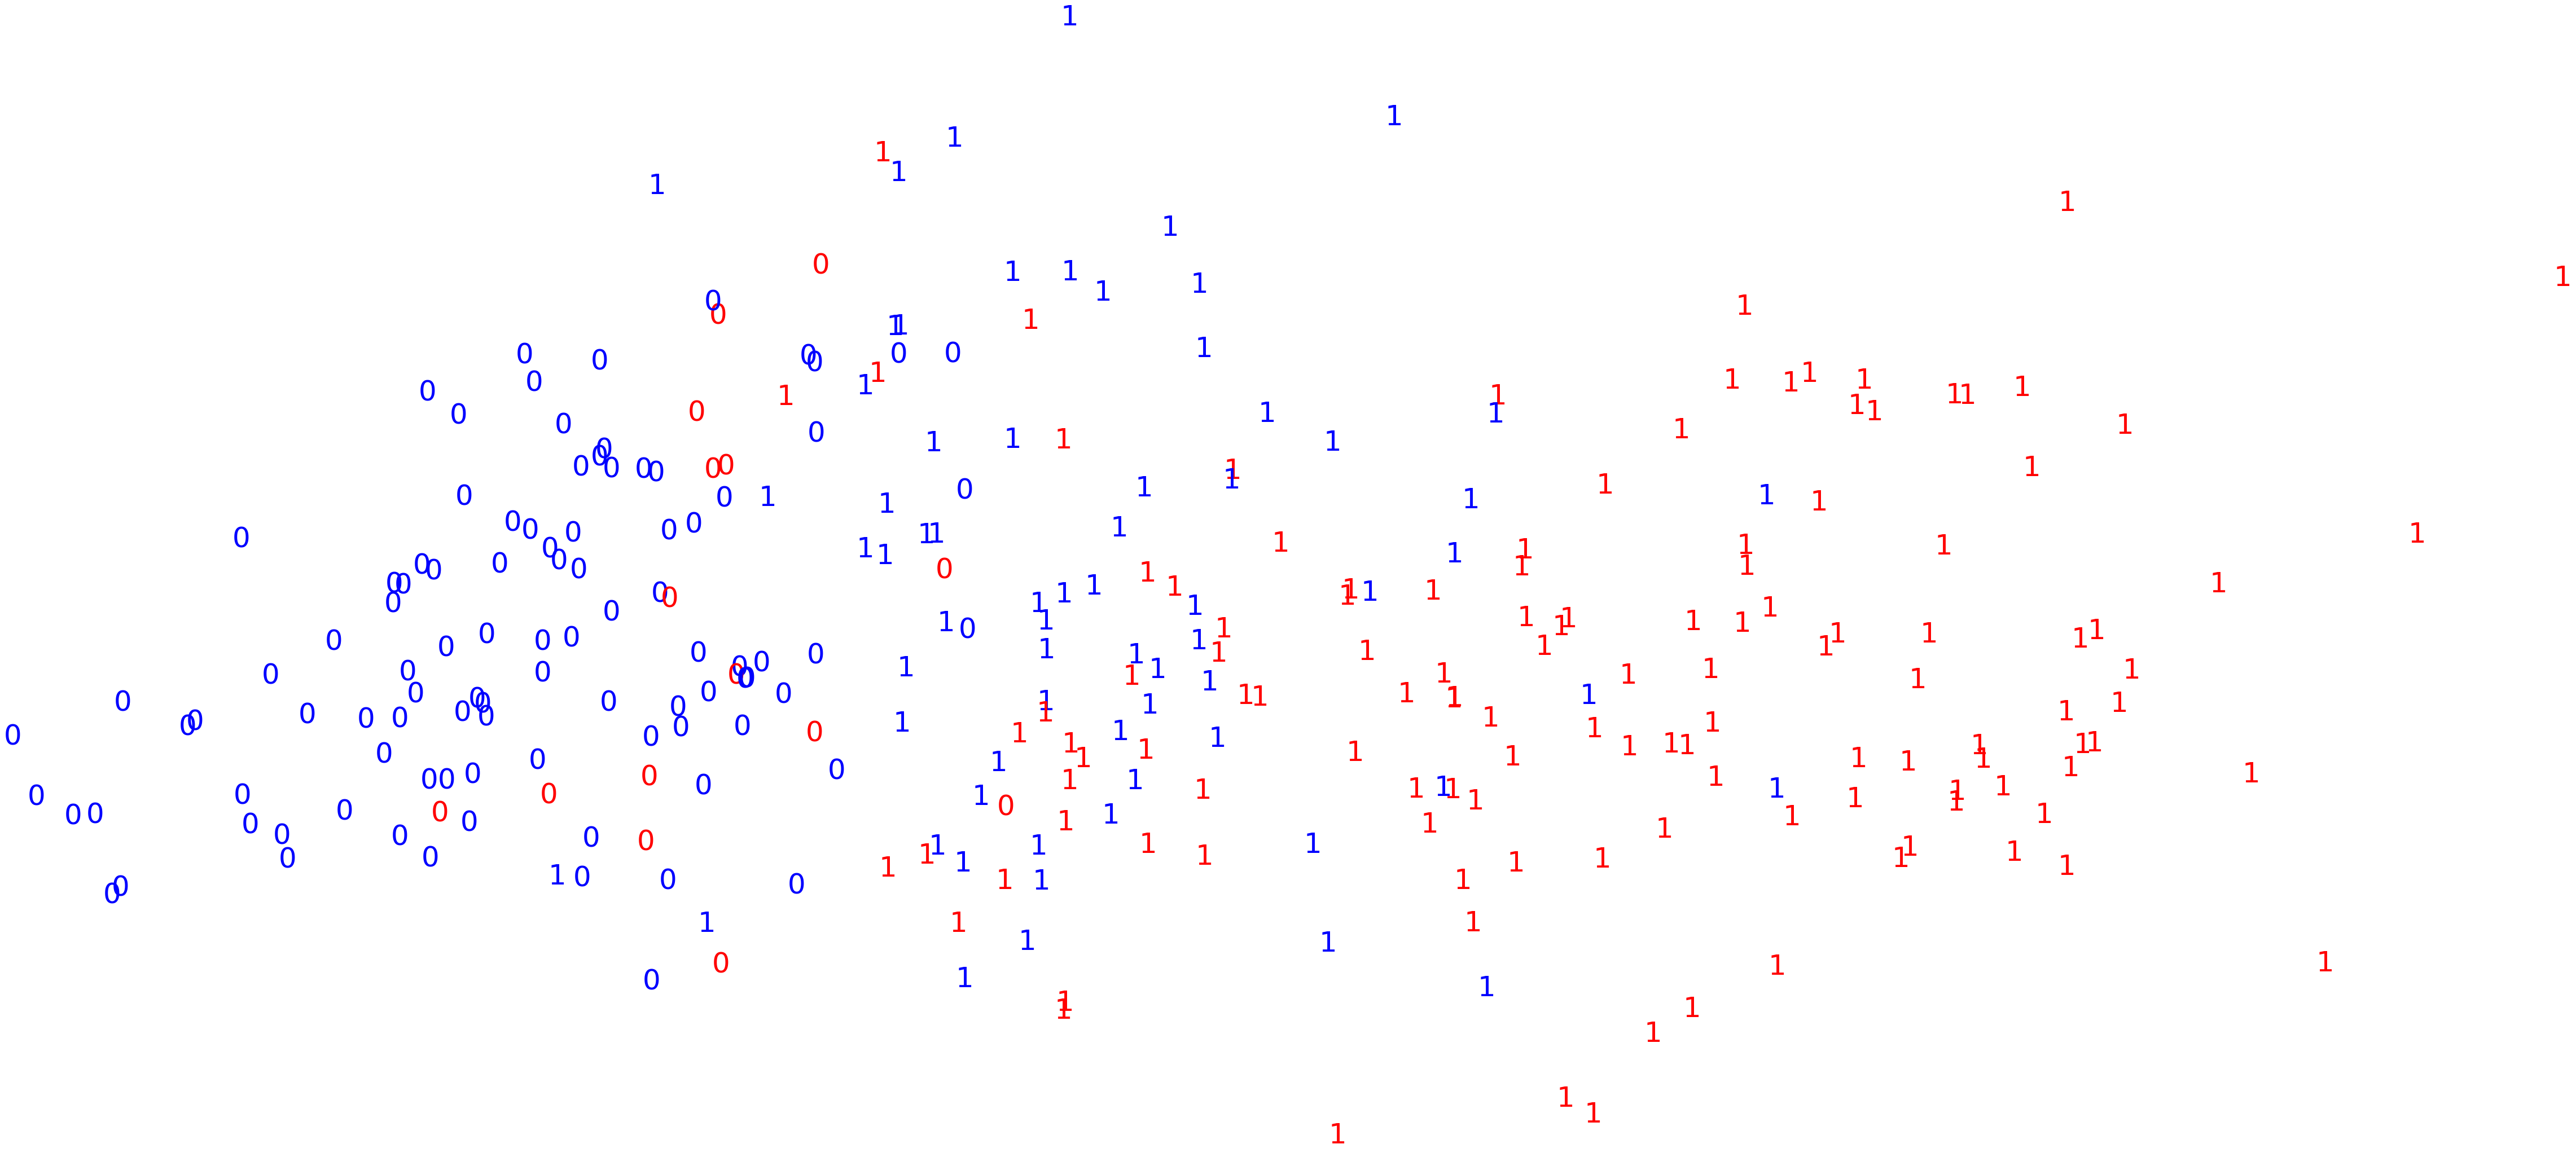

In [114]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [115]:
# re-labeling clusters
clusters = np.array([2 if x == 1 else 1 if x==0 else 0 for x in clusters])

pd.crosstab(y,clusters)

col_0,1,2
row_0,,
0,15,124
1,97,67


In [116]:
# Examine ARI and silhouette score
results_df.loc['gaussian - spherical', 'silhouette'] = round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)
round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3)

0.125

In [117]:
results_df.loc['gaussian - spherical', 'ARI'] = round(metrics.adjusted_rand_score(y, clusters), 3)
round(metrics.adjusted_rand_score(y, clusters), 3)

0.208

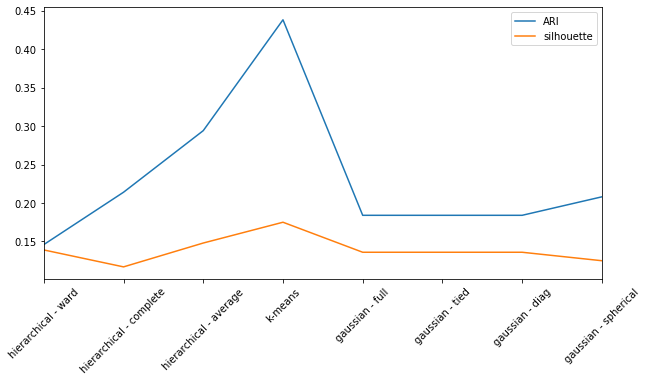

In [119]:
results_df.plot(figsize=(10,5))
plt.xticks(rotation=45);